<center>
<img src="https://raw.githubusercontent.com/dvgodoy/PyTorch101_ODSC_Europe2020/master/images/linear_dogs.jpg" width="800">

# Основы глубинного обучения: домашнее задание 4
</center>

**ФИО:** Еськов Михаил Михайлович

**Забавный факт о себе:**

## Общая информация

__Дата выдачи:__ 09.12.2023

__Дедлайн:__ 23:59MSK 18.12.2023

В случае этой домашки мягкий дедлан совпадает с жёстким.

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 5.2 балла (3 основных балла и ещё 2.2 бонусных).

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

In [2]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Описание данных

Данные можно [скачать с гугл-диска.](https://drive.google.com/drive/folders/11oCcLplWtp_qm-WuEbfCFP_Mz5K_z3ps?usp=sharing) Если вы делаете задание в колабе, то строчки ниже сами скачают вам данные.



In [3]:
import gdown
url1 = 'https://drive.google.com/drive/folders/1ZZGl4fhzQbYkD8a-MqaZZm7p535UQ-l5?usp=sharing'
url = "https://drive.google.com/drive/folders/11oCcLplWtp_qm-WuEbfCFP_Mz5K_z3ps?usp=sharing"
gdown.download_folder(url1, quiet=True, use_cookies=False)

['/content/texts/ria_news.tsv',
 '/content/texts/vk_comments.tsv',
 '/content/texts/vk_news.tsv']

В таблице `ria_news.tsv`  лежат данные о новостях, вышедших на сайте РИА-НОВОСТИ с 15 марта 2018 года по 31 декабря 2018 года.

- `href` - уникальный идентификатор новости (ссылка на неё)
- `date` - дата публикации новости
- `time` - время публикации новости
- `title` - заголовок новости
- `snippet` - краткое описание новости
- `text` - текст новости
- `category` - категория новости
- `keywords` - ключевые слова (подкатегории новости)
- `shows` - счётчик с числом просмотров новости на сайте (на момент парсинга)

In [4]:
df_ria = pd.read_csv('texts/ria_news.tsv', sep='\t')
df_ria = df_ria[~df_ria.tags.isnull()]
print(df_ria.shape)
df_ria.head()

(201708, 9)


,href,date,time,title,snippet,text,category,tags,shows
0,/20181231/1548961410.html,2018-12-31,"31 декабря 2018, 23:52",Нетаньяху не собирается в отставку в случае пр...,Премьер-министр Израиля Биньямин Нетаньяху не ...,"МОСКВА, 31 дек - РИА Новости. Премьер-министр ...",В мире,"Биньямин Нетаньяху, Израиль, В мире",728.0
1,/20181231/1548961364.html,2018-12-31,"31 декабря 2018, 23:19",Макрон в новогоднем обращении затронул тему ре...,"Результат реформ не может быть мгновенным, зая...","ПАРИЖ, 31 дек – РИА Новости. Результат реформ ...",В мире,"Эммануэль Макрон, Франция, В мире",3086.0
2,/20181231/1548961337.html,2018-12-31,"31 декабря 2018, 23:12",Аарон Рэмзи проведет переговоры с пятью топ-кл...,"Полузащитник лондонского ""Арсенала"" Аарон Рэмз...","МОСКВА, 31 дек - РИА Новости. Полузащитник лон...",NaN,ФК Арсенал (Лондон),183.0
3,/20181231/1548961304.html,2018-12-31,"31 декабря 2018, 23:09",Гол Азмуна принес сборной Ирана победу над кат...,Футболисты сборной Ирана одержали победу над к...,"МОСКВА, 31 дек - РИА Новости. Футболисты сборн...",NaN,"Сердар Азмун, Сборная Ирана по футболу",78.0
4,/20181231/1548961265.html,2018-12-31,"31 декабря 2018, 23:07",Пятая ракетка мира дель Потро пропустит Открыт...,Аргентинский теннисист Хуан Мартин дель Потро ...,"МОСКВА, 31 дек - РИА Новости. Аргентинский тен...",NaN,Теннис,79.0


Многие новостные агенства поддерживают странички в социальных сетях. Они постят туда самые сочные сюжеты. В таблице `vk_news.tsv` лежат данные о новостях, которые РИА запостили ВКонтакте в период времени с  `2017-09-29 01:28:55` по `2019-02-01 23:13:17`.

- `id` - уникальный идентификатор поста
- `href` - ссылка на сайт (если она была указана в посте)
- `datetime` - дата и время публикации новости
- `title` - заголовок новости
- `text` - текст новости в социальной сети
- `likes` - число лайков под постом
- `comments` - число комментариев под постом

In [5]:
df_vk = pd.read_csv('texts/vk_news.tsv', sep='\t')
df_vk['snippet'] = df_vk['text']
df_vk.drop('text', axis=1, inplace=True)
print(df_vk.shape)
df_vk.head()

(19928, 7)


,id,href,datetime,title,likes,comments,snippet
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN


В таблице `vk_comments.tsv` лежат комментарии к новостям.

- `id` - уникальный идентификатор комментария
- `post_id` - идентификатор новости, под которой был оставлен комментарий
- `datetime` - дата и время, когда был оставлен комментарий
- `text` - текст комментария
- `likes` - число лайков под комментарием

In [6]:
df_comments = pd.read_csv('texts/vk_comments.tsv', sep='\t')
df_comments = df_comments[~df_comments.text.isnull()]
print(df_comments.shape)
df_comments.head()

<ipython-input-6-d43eec125c32>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_comments = pd.read_csv('texts/vk_comments.tsv', sep='\t')


(2612629, 5)


,id,post_id,datetime,text,likes
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0


# А что надо сделать то?

В тетрадке вам предстоит сделать следующие шаги:

1. Вы обучите нейросеть предсказывать категорию новости
2. Вы построите предсказания для тех новостей, где мы ничего не знаем о категории
3. Вы используете уже обученный для сентимент-анализа классификатор из библиотеки `hugging face` чтобы предсказать эмоциональную окраску каждого комментария
4. Вы проведёте аналитику по новостям, а именно построите топы из самых позитивных и негативных категорий и новостей

Для первого шага вам будет дан бэйзлайн. Если вы его прогоните, у вас получится базовая модель, которая даст некоторое качество решения задачи. Вам надо будет выяснить, насколько это качество оказалось хорошим, а затем внести в код некоторые улучшения.



## Часть 1: категоризация новостей (1.2 + 2 бонусных балла)

Каждой новости в соотвествие поставлены ключевые слова. Будем считать, что эти ключевые слова — тематики новости. Нужно научиться предсказывать тематики по тексту новости. Готовые тематики у нас есть только по новостям с сайта. Они за 2018 год. По новостям из ВКонтакте у нас тематик нет. Мы собираемся их предсказать.

Новости, опубликованные ВКонтакте, отличаются от новостей с сайта тем, что у них есть только титул и короткое описание. Странно будет обучать нейросеть на длинных текстах, а потом использовать её на коротких описаниях. Мы не будем так делать. Мы попробуем обучить базовый вариант нейронной сети только на заголовках новостей. Все, кто захочет получить бонусные баллы, смогут попробовать добавить в нейросеть сниппеты (так назыают короткие описания новостей).

## 1.1 Подготовка таргета

Поработаем с таргетом. Мы будем предсказывать переменную `tags`. Давайте выясним скоько уникальных тегов существует.

In [7]:
from collections import Counter

# удалим все лишние пробелы и сделаем lowercase
df_ria['tags'] = (
    df_ria.tags.
    apply(lambda w: ','.join([item.strip() for item in  w.lower().split(',')]))
)

tags = ','.join(list(df_ria.tags.values))
tags_cnt = Counter(tags.split(','))

print(len(tags_cnt))
tags_cnt.most_common()[-20:]

13344


[('блог анны завершинской об автоспорте - блоги', 1),
 ('министерство транспорта рб', 1),
 ('министерство здравоохранения грузии', 1),
 ('палех', 1),
 ('юрий посохов (хореограф)', 1),
 ('мария александрова', 1),
 ('том бенсон', 1),
 ('абдул каюм кочай', 1),
 ('нуман куртулмуш', 1),
 ('mipim', 1),
 ('владимир попов', 1),
 ('брюно женезио', 1),
 ('роберт фицо', 1),
 ('сергей пашинский', 1),
 ('валерия гонтарева', 1),
 ('нововоронеж', 1),
 ('императорское православное палестинское общество', 1),
 ('event_poslanie_prezidenta_rf_federalnomu_sobraniju', 1),
 ('фхтр', 1),
 ('игорь честин', 1)]

Всего в выборке есть порядка 13 000 тэгов. Многие встречаются всего по разу. Давайте оставим в выборке только те тэги, которые встречаются более 30 раз.

In [8]:
target_tags = {tag for tag,cnt in tags_cnt.most_common() if cnt > 30}
len(target_tags)

1583

Закодируем теги для OHE.

In [9]:
tag2idx = dict(zip(target_tags, range(len(target_tags))))
idx2tag = {jtem: item for item,jtem in tag2idx.items()}

Почистим таргет от лишних тэгов.

In [10]:
df_ria['target_tags'] = (
    df_ria.tags.
    apply(lambda w: [tag2idx.get(item) for item in  w.split(',') if item in target_tags])
)

df_ria = df_ria[df_ria.target_tags.apply(len) > 0]
df_ria.shape

(201437, 10)

In [11]:
df_ria.target_tags.values[:3]

array([list([917, 1357, 792]), list([21, 1523, 792]), list([1570])],
      dtype=object)

## 1.2 Подготовка текстов

Теперь займёмся предобработкой текстов. Приведём все слова к маленькому регистру и выбросим мусорные символы. В качестве токенов будем рассматривать отдельные слова.

Напомню, что мы пока что решили работать только с названиями статей. Поэтому вся предобработка применяется исключительно к ним. **Спойлер:** предобработку для сниппетов вы сделаете сами в первом же задании.

In [12]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
import re
from nltk.tokenize import word_tokenize

def normalise_text(text):
  if text == '#UNKN':
    return text
  text = text.lower()

    # сурово регулярками выкидываем мусорные символы
  text = re.sub('[^а-яa-z0-9 ]', '', text)
  return text.strip()

df_ria['title_clean'] = df_ria.title.apply(normalise_text)

word_cnt = Counter(word_tokenize(' '.join(df_ria.title_clean.values)))
len(word_cnt)

112178

In [14]:
word_cnt.most_common()[:10]

[('в', 127323),
 ('на', 44386),
 ('с', 26150),
 ('и', 21771),
 ('о', 19948),
 ('по', 17014),
 ('россии', 13494),
 ('не', 13483),
 ('сша', 9942),
 ('за', 9881)]

Давайте почистим словарь от стоп-слов и подготовим его к использованию внутри датасета. Мы будем с помощью словаря заменять слова на индексы. Добавим в словарь несколько специальных токенов для неизвестных слов и паддингов.

In [15]:
from nltk.corpus import stopwords

stops_ru = set(stopwords.words('russian'))
len(stops_ru)

151

In [16]:
vocabulary = {
    "#PAD#": 0, "#UNK#": 1
}

k = 2
for word, _ in word_cnt.most_common():
    if word not in stops_ru:
        vocabulary[word] = k
        k += 1

In [17]:
len(vocabulary)

112030

Завернём код для создания словаря в функцию.

In [18]:
def create_vocab(text, stops_ru=stops_ru):

    word_cnt = Counter(word_tokenize(text))
    vocabulary = {
        "#PAD#": 0, "#UNK#": 1
    }

    k = 2
    for word, _ in word_cnt.most_common():
        if word not in stops_ru:
            vocabulary[word] = k
            k += 1
    return vocabulary

In [19]:
df_vk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19928 entries, 0 to 19927
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        19928 non-null  int64 
 1   href      19928 non-null  object
 2   datetime  19928 non-null  object
 3   title     19928 non-null  object
 4   likes     19928 non-null  int64 
 5   comments  19928 non-null  int64 
 6   snippet   6525 non-null   object
dtypes: int64(3), object(4)
memory usage: 1.1+ MB


__[0.2 балла] Задание 1:__

- Cделайте аналогичную предобработку титулов из таблички `df_vk`. Запишите получившийся результат в столбец `title_clean` по аналогии с таблицей `df_ria`.
- Сделайте для обеих таблиц предобработку колонок со сниппетами `snippet` и запишите получившийся результат в столбец `snippet_clean`. Все пропуски заполните токеном `"#UNKN"`.

In [20]:
df_vk['title_clean'] = df_vk.title.apply(normalise_text)
df_vk['snippet'] = df_vk['snippet'].fillna('#UNKN')
df_vk['snippet_clean'] = df_vk.snippet.apply(normalise_text)
df_ria['snippet'] = df_ria['snippet'].fillna('#UNKN')
df_ria['snippet_clean'] = df_ria.snippet.apply(normalise_text)


## 1.3 Поставка данных

Пересечение сайта и ВК по опубликованным новостям довольно маленькое. Мы обучаем модель на данных с сайта. Предсказания мы будем строить на данных из ВК. У этих данных разная природа. В ВК описание статей и заголовки короче. Модель может хорошо показать себя на данных с новостного сайта, но сильно просесть в качестве на данных из ВК.

Давайте сохраним пересечение в отдельную табличку, чтобы на нём можно было понять, насколько сильно деградирует модель.

In [21]:
ria_hrefs = set(df_ria.href.values)
vk_hrefs = set(df_vk.href.values)
test_hrefs = (vk_hrefs & ria_hrefs)

print('Размер отложенной выборки:', len(test_hrefs))

df = df_ria[~df_ria.href.isin(test_hrefs)]

Размер отложенной выборки: 1128


По странному совпадению (я правда не знаю почему) пересечение лежит в декабре. Мы будем его использовать как тестовую выборку.

In [22]:
df_ria[df_ria.href.isin(test_hrefs)].date.min(), df_ria[df_ria.href.isin(test_hrefs)].date.max()

('2018-12-06', '2018-12-31')

Предположим, что мы делим выборку на обучающую и тестовую случайно. За один и тот же промежуток времени может выйти довольно большое число новостей с одинаковым заголовком. Давайте представим себе, что в тесте и трэйне есть много статей про одно и то же событие. Модель научилась на обучающей выборке хорошо его тегировать. Остальные события модель тегирует намного хуже. Метрики на тестовой выборке высокие. В следующем месяце СМИ перестают освещать это событие, в потоке новостей совершенно другие новости. Качество модели резко проседает.

Чтобы не напороться на завышенные метрики, обычно выборку дробят на обучающую и тестовую по времени. Тогда статьи из теста будут имитировать поток новых новостей, освещающих новые события.

In [23]:
df.date.min(), df.date.max()

('2018-03-15', '2018-12-31')

__[0.2 балла] Задание 2:__ Разбейте выборку на обучающую, валидационную и тестовую. В тест возьмите весь декабрь. В валидацию октябрь и ноябрь.

In [24]:
df_test = df_ria[(df_ria.date >= '2018-12-01')]
df_val = df_ria[(df_ria.date < '2018-12-01') & (df.date >= '2018-10-01')]
df_train = df_ria[(df_ria.date < '2018-10-01')]

Сформируем отложенную выборку (пересечение ВКонтакте и РИА).

In [25]:
df_oob = df_vk[df_vk.href.isin(test_hrefs)][['href', 'title_clean']]

df_ria_oob = df_ria[df_ria.href.isin(test_hrefs)][['href', 'target_tags']]
df_oob = df_oob.set_index('href').join(df_ria_oob.set_index('href')).reset_index()
df_oob.head()

,href,title_clean,target_tags
0,/20181206/1547493936.html,эксперты определили самые бюджетные экзотическ...,"[105, 600]"
1,/20181206/1547516457.html,рада приняла закон расширяющий контролируемую ...,"[735, 792]"
2,/20181206/1547520788.html,россия оказалась родиной древнейших титанозавр...,"[185, 608]"
3,/20181206/1547521406.html,школа в красноярске превратилась в хогвартс из...,[1173]
4,/20181206/1547522342.html,рада решила не продлевать договор о дружбе и с...,"[623, 792]"


Напишем датасет для поставки данных в нейросеть.


In [26]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class NewsDataset(Dataset):

    def __init__(self, target, title, vocab, vocab_size, max_title_len, max_classes, snippet=None, max_snippet_len=None):

       self.vocab = {word: idx  for word,idx in vocab.items() if idx < vocab_size}
       self.max_classes = max_classes
       self.y=self.target_ohe(target)
       self.X_title = self.create_text(title, max_title_len)
       if snippet is None:
          self.X_snippet = torch.zeros_like(self.X_title)
       else:
          self.X_snippet = self.create_text(snippet, max_snippet_len)

    def target_ohe(self, target):
        y = torch.zeros((len(target), self.max_classes))
        for i, t in enumerate(target):
            y[[i]*len(t), t] = 1.0
        return y

    def create_text(self, texts, max_len):
        result = [ ]
        for sent in texts:
            # {#PAD: 0, #UNKN: 1}
            sent_tokenize = [self.vocab.get(item, 1) for item in word_tokenize(sent)]

            # приводим все тексты к max_len
            if len(sent_tokenize) >= max_len:
                sent_tokenize = sent_tokenize[:max_len]
            else:
                sent_tokenize += [0] * (max_len - len(sent_tokenize))
            result.append(sent_tokenize)
        return torch.tensor(result, dtype=torch.int)

    def __len__(self):
        return len(self.X_title)

    def __getitem__(self, idx):
        return ((self.X_title[idx, :], self.X_snippet[idx, :]), self.y[idx])

__[0.2 балла] Задание 3:__ Сейчас датасет умеет работать только с полем `title_clean`. Давайте сделаем этот датасет более многофукнциональным и добавим в него возможность добавить в обработку данных сниппет.

1. Внутри датасета `snippet` надо обработать точно также как и `title`.
2. Если `snippet=None`, датасет должен вернуть два объекта: `X_title, y`. В обратном случае датасет должен вернуть три объекта.

**Важно:** Весь код ниже работает сейчас без сниппета. Он не должен развалиться от того, что сниппет в нём нигде не указан.

In [27]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

# Внесите в код датасета выше свои правки

Объявим датасеты, оставим в словаре 30 000 самых частотных слов. Будем смотреть на титулы максимальной длины 20.

In [28]:
CLASSES_NUM = len(idx2tag)
VOCAB_SIZE = 10000
MAX_TITLE_LEN = 20

# словарь создаем по всей выборке
vocabulary = create_vocab(' '.join(df_ria.title_clean.values))

# объявляем датасеты
train_dataset = NewsDataset(df_train.target_tags.values, df_train.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM, df_train.snippet_clean.values, MAX_TITLE_LEN )
val_dataset = NewsDataset(df_val.target_tags.values, df_val.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM, df_val.snippet_clean.values, MAX_TITLE_LEN  )
test_dataset = NewsDataset(df_test.target_tags.values, df_test.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM, df_test.snippet_clean.values, MAX_TITLE_LEN  )

In [29]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=32, num_workers=4)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=2048, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## 1.4 Архитектуры

Соберём базовую архитектуру для обучения.

In [30]:
from torch import nn
import torch.nn.functional as F

class SimpleClassifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, title):
        title, snippet = title
        embedded_title = self.embedding(title)
        embedded_title = embedded_title.mean(dim=1)
        return self.fc(embedded_title)

In [31]:
class SimpleClassifier_v2(nn.Module):

    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim*2, output_dim)

    def forward(self, title):

        title, snippet = title

        embedded_title = self.embedding(title)
        embedded_snippet = self.embedding(snippet)
        embedded_snippet = embedded_snippet.mean(dim=1)
        embedded_title = embedded_title.mean(dim=1)
        result = torch.cat((embedded_snippet, embedded_title), dim = 1 )
        return self.fc(result)

Соберём в `pytorch_lightning` модуль для обучения нейронки.

In [32]:
!pip3 install pytorch_lightning
!pip install wandb

In [33]:
import wandb
wandb.login()

wandb: Currently logged in as: mic-eskov (eskov). Use `wandb login --relogin` to force relogin


True

In [34]:
import pytorch_lightning as pl

class TrainLightningModule(pl.LightningModule):
    def __init__(self, model, learning_rate, criterion, Adam = True, momentum = 0.7):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.Adam = Adam

    def forward(self, title):
        result = self.model(title)
        return result

    def configure_optimizers(self):
        if self.Adam:
          optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        else:
          optimizer = optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate, momentum = self.momentum)
        return optimizer

    def training_step(self, train_batch, batch_idx):

        title, target = train_batch

        logits = self.model(title)
        loss = self.criterion(logits, target)
        self.log(
            "train_loss", loss, prog_bar=True
        )
        wandb.log({"train_loss": loss})
        return loss

    def validation_step(self, val_batch, batch_idx):

        title, target = val_batch
        logits = self.model(title)
        loss = self.criterion(logits, target)
        self.log(
            "val_loss", loss, prog_bar=True
        )
        wandb.log({"val_loss": loss})
        return loss

Обучим модель.

In [ ]:
EMBEDDING_DIM = 300
EPOCHS = 5
LR = 1e-3
run = wandb.init(
    # Set the project where this run will be logged
    project="without_snippet",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": LR,
        "epochs": EPOCHS,
    },
)
model_baseline = SimpleClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
criterion = torch.nn.CrossEntropyLoss()

train_module =TrainLightningModule(model_baseline, LR, criterion)

trainer = pl.Trainer(accelerator="gpu", max_epochs=EPOCHS)
trainer.fit(train_module, train_dataloader, val_dataloader)

train_loss,█▅▇▆▅▅▅▃▄▄▅▃▄▂▂▅▃▄▁▄▃▃▃▃▃▂▂▂▂▂▃▃▂▁▁▃▁▁▂▂
val_loss,█▇▃▃▃▂▃▂▂▂▂▂▂▂▃▂▁▃▂▂▂▂▃▁▁▃▂▂▂▂▂▁▁▂▂▂▂▃▂▁
train_loss,4.15072
val_loss,8.58111


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | SimpleClassifier | 3.5 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
13.906    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
torch.save(model_baseline, '/content/drive/MyDrive/Models/model_baseline.pth')

In [ ]:
EMBEDDING_DIM = 300
EPOCHS = 5
LR = 1e-3
run = wandb.init(
    # Set the project where this run will be logged
    project="with_snippet",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": LR,
        "epochs": EPOCHS,
    },
)
model_baseline_v2 = SimpleClassifier_v2(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
criterion = torch.nn.CrossEntropyLoss()

train_module =TrainLightningModule(model_baseline_v2, LR, criterion)

trainer = pl.Trainer(accelerator="gpu", max_epochs=EPOCHS)
trainer.fit(train_module, train_dataloader, val_dataloader)

train_loss,█▇▆▅▄▆▄▄▄▃▅▅▂▂▁▃▂▃▃▃▂▁▂▁▂▁▂▃▂▂▁▂▂▁▂▂▃▃▂▁
val_loss,█▇▃▃▃▃▃▃▂▂▂▂▂▂▃▂▂▃▁▂▂▂▃▁▁▃▂▂▂▂▂▁▁▁▂▁▂▃▂▁
train_loss,6.69638
val_loss,9.17556


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                | Params
--------------------------------------------------
0 | model     | SimpleClassifier_v2 | 4.0 M 
1 | criterion | CrossEntropyLoss    | 0     
--------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.806    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
torch.save(model_baseline_v2, '/content/drive/MyDrive/Models/model_baseline_v2.pth')

__[0.2 балла] Задание 4:__  Модель выше работает только с титулом.

- Залоггируйте её обучение на [WandB](https://wandb.ai/).
- Соберите архитектуру, которая будет принимать на вход не только титул, но ещё и сниппет. В этой архитектуре должно происходить следующее:

1. Общий слой `nn.Embedding` применяется к сниппету и титулу параллельно.
2. Происходит усреднее по текстам.
3. Вектора конкатятся в один длины 600
4. Линейный слой делает классификацию

Обучите эту модель. Сравните траектории обучения на WandB. Прикрепите ссылку на дашборд либо скришот к тетрадке.

Даталоадеры придётся объявить заново с учётом сниппетов. Правда ли, что она бьёт на валидационной выборке модель, обученную только на титулах статей?

**Ответ:** Правда, но не критично

#### Для модели со сниппетами:

https://api.wandb.ai/links/eskov/uucf64eu

https://api.wandb.ai/links/eskov/fqm24hfs

#### Для модели без сниппетов:

https://api.wandb.ai/links/eskov/ywp0br1z

https://api.wandb.ai/links/eskov/e164srjv

Графики могли быть красивее, но WandbLogger не захотел работать :(

## 1.5 Инференс и оценка качества моделей

Для каждой новости нам надо предсказывать несколько тэгов. То есть в нашем случае настоящее значение таргета это множество из тэгов $y_i = [tag1, tag2, tag3]$. Прогноз модели также множество из тэгов $\hat y_i = [tag1, tag4]$.

Будем считать метрики качества следующим образом (под $|A|$ имеется в виду мощность множества, то есть число элементов в нём):

$$
Precision = \frac{1}{n} \sum_{i = 1}^n \frac{|y_i \cap \hat{y}_i|}{|\hat{y}_i|}
$$

$$
Recall = \frac{1}{n} \sum_{i = 1}^n \frac{|y_i \cap \hat{y}_i|}{|y_i|}
$$

Также можно считать аналог Accuracy, но это не самая удачная идея, так как у нас в выборке огромное число нулей и эта метрика при любом разумном пороге для принятия решения будет очень высокой.

$$
Exact Match = \frac{1}{n} \cdot \frac{1}{k} \sum_{i = 1}^n \sum_{k=1}^K [y_{ij} = \hat{y}_{ij}]
$$

In [ ]:
def precision(target, y_pred):
    num = ((y_pred == 1) & (target == 1)).sum(dim=1)
    denum = (y_pred == 1).sum(dim=1)
    return (num/(denum + 1e-5)).mean().item()

def recall(target, y_pred):
    num = ((y_pred == 1) & (target == 1)).sum(dim=1)
    denum = (target == 1).sum(dim=1)
    return (num/(denum + 1e-5)).mean().item()

def exact_match(target, y_pred):
    return (1.*(y_pred == target)).mean().item()

Построим прогноз на тестовой выборке.

In [ ]:
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=test_dataset.__len__())

for title, target in test_dataloader:
    logit = model_baseline(title)
    pred_prob = F.softmax(logit, dim=1)

assert pred_prob.shape[0] == test_dataset.__len__()

Теперь выбирая различное значение порога, мы можем получать разные предсказания. Если взять очень большое значение порога, то метрики сильно просядут, так как во многих документах никакого прогноза не будет построено вообще.

In [ ]:
TRESHOLD = 0.01
y_pred = 1*(pred_prob > TRESHOLD)

print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.9956179857254028
Precision: 0.3010717034339905
Recall: 0.7742161154747009


In [ ]:
TRESHOLD = 0.05
y_pred = 1*(pred_prob > TRESHOLD)
print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.998306393623352
Precision: 0.519339382648468
Recall: 0.6360042691230774


In [ ]:
TRESHOLD = 0.9
y_pred = 1*(pred_prob > TRESHOLD)

print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.9983222484588623
Precision: 0.007651067804545164
Recall: 0.00667473953217268


Дальше мы будем строить довольно много прогнозов. Давайте напишем код для их строительства в виде функции. Обратите внимание, что на модели со снипетом она упадёт. Когда вы доберётесь до строительства прогнозов, функцию придётся немного модернизировать.

In [ ]:
def get_predict(model, dataset):
    dataloader = DataLoader(dataset, shuffle=False, batch_size=dataset.__len__())

    for title, target in dataloader:
        logit = model(title)
        pred_prob = F.softmax(logit, dim=1)

    assert pred_prob.shape[0] == dataset.__len__()
    return pred_prob, target

__[0.2 балла] Задание 5:__ Какая метрика для нас в этой задаче важнее? Точность или полнота? Почему?

__ваш ответ:__ precision в нашей задаче важнее. Если мы будем максимизировать recall, то наша модель может начать выдавать много "мусорных тэгов", что не есть хорошо. Лучше если бы модель пыталась предсказывать истинные тэги.

- Напишите функцию, которая будет подбирать оптимальное значение порога, оптимизирующее выбранную вами метрику.
- Подберите значение порога на валидационной выборке.
- Сравните модель со сниппетами и без сниппетов, используя выбранную вами метрику при оптимальном значении порога на тестовой выборке.
- Какая из них оказалась лучше?

In [ ]:
def find_best_precision(pred_prob, target, print_results = False):
  best_precision = 0
  threshold_best = 0
  for threshold in np.arange(0, 1, 0.05):
    y_pred = 1*(pred_prob > threshold)
    current_precision = precision(target, y_pred)
    if current_precision > best_precision:
      best_precision = current_precision
      threshold_best = threshold
  if print_results:
    y_pred = 1*(pred_prob > threshold_best)
    print('Exact Match:', exact_match(target, y_pred))
    print('Precision:', precision(target, y_pred))
    print('Recall:', recall(target, y_pred))
    print('Лучший порог:', threshold_best)
  return best_precision, threshold_best


In [ ]:
print("Для модели со сниппетами:")
find_best_precision(*get_predict(model_baseline_v2, test_dataset), True)
pass

Для модели со сниппетами:
Exact Match: 0.9985764622688293
Precision: 0.5855863094329834
Recall: 0.4215797483921051
Лучший порог: 0.15000000000000002


In [ ]:
print("Для модели без сниппетов:")
find_best_precision(*get_predict(model_baseline, test_dataset), True)
pass

Для модели без сниппетов:
Exact Match: 0.9986072778701782
Precision: 0.5861341953277588
Recall: 0.4359953701496124
Лучший порог: 0.15000000000000002


__[0.2 балла] Задание 6:__  Постройте прогнозы для отложенной выборки, которая представляет из себя пересечение сайта РИА-новостей и ВКонтакте. Проседает ли на ней качество модели? Насколько сильно?

In [ ]:
df_oob.head()

,href,title_clean,target_tags
0,/20181206/1547493936.html,эксперты определили самые бюджетные экзотическ...,"[1483, 678]"
1,/20181206/1547516457.html,рада приняла закон расширяющий контролируемую ...,"[263, 165]"
2,/20181206/1547520788.html,россия оказалась родиной древнейших титанозавр...,"[315, 754]"
3,/20181206/1547521406.html,школа в красноярске превратилась в хогвартс из...,[1251]
4,/20181206/1547522342.html,рада решила не продлевать договор о дружбе и с...,"[1052, 165]"


In [ ]:
oob_dataset = NewsDataset(df_oob.target_tags.values, df_oob.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM)
print("Для модели со сниппетами на отложеной выборке:")
find_best_precision(*get_predict(model_baseline_v2, oob_dataset), True)
pass

Для модели со сниппетами на отложеной выборке:
Exact Match: 0.998112678527832
Precision: 0.2653699815273285
Recall: 0.12394143640995026
Лучший порог: 0.15000000000000002


In [ ]:
print("Для модели со сниппетами на отложеной выборке:")
find_best_precision(*get_predict(model_baseline, oob_dataset), True)
pass

Для модели со сниппетами на отложеной выборке:
Exact Match: 0.9986116886138916
Precision: 0.5617054104804993
Recall: 0.390535831451416
Лучший порог: 0.15000000000000002


Качество модели без сниппетов упало, но несильно. Для модели со сниппетами качество, очевидно, упало сильно.

## 1.6 Бонусное задание

Давайте модернизируем наши архитектуры настолько, насколько это возможно.

__[0.5 балла]__ Попробуйте собрать более большую архитектуру. Например, сразу после слоя эмбеддингов вы можете попробовать добавить свёрточные слои (`Conv1D` свёртки). Поиграйте с оптимизатором и тп.

Опишите результаты своих экспериментов ниже. Расскажите, что конкретно вы делали и удалось ли вам улучшить качество модели. Все траектории обучения залоггируйте на WandB.   

__Ваш лог экспериментов:__

1) https://api.wandb.ai/links/eskov/hjuhvnhd
https://api.wandb.ai/links/eskov/3l8j7s21

2) https://api.wandb.ai/links/eskov/erih0bhc
https://api.wandb.ai/links/eskov/7k1241jh

3)https://api.wandb.ai/links/eskov/qyt38j14
https://api.wandb.ai/links/eskov/5hvqzdev

In [35]:
class conv2(nn.Module):

    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = torch.nn.Conv1d(20,20, kernel_size = 2)
        self.conv_2 = torch.nn.Conv1d(20,20,kernel_size = 3 , padding =1)
        #self.conv_3 = torch.nn.Conv1d(20,2,kernel_size = 4,  padding =2)
        self.conv_11 = torch.nn.Conv1d(20,20, kernel_size = 2)
        self.conv_22 = torch.nn.Conv1d(20,20, kernel_size = 3, padding =1)
        #self.conv_33 = torch.nn.Conv1d(20,2,kernel_size = 4, padding =2)

        self.fc = nn.Linear(598, output_dim)

    def forward(self, title):

        title, snippet = title

        embedded_title = self.embedding(title)
        embedded_snippet = self.embedding(snippet)

        embedded_snippet = self.conv_1(embedded_snippet)
        embedded_snippet =  self.conv_2(embedded_snippet)
        embedded_title = self.conv_11(embedded_title)
        embedded_title = self.conv_22(embedded_title)

        embedded_snippet = embedded_snippet.mean(dim=1)
        embedded_title = embedded_title.mean(dim=1)


        result = torch.cat((embedded_snippet, embedded_title), dim = 1 )
        return self.fc(result)

In [67]:
import wandb
wandb.login()

True

In [36]:
EMBEDDING_DIM = 300
EPOCHS = 5
LR = 1e-3

run = wandb.init(
    # Set the project where this run will be logged
    project="conv2",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": LR,
        "epochs": EPOCHS,
    },
)

conv2_model = conv2(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
criterion = torch.nn.CrossEntropyLoss()

train_module =TrainLightningModule(conv2_model, LR, criterion)

trainer = pl.Trainer(accelerator="gpu", max_epochs=EPOCHS)
trainer.fit(train_module, train_dataloader, val_dataloader)
torch.save(conv2_model, '/content/drive/MyDrive/Models/conv2_model.pth')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | conv2            | 4.0 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.809    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [37]:
class conv3(nn.Module):

    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = torch.nn.Conv1d(20,20, kernel_size = 2)
        self.conv_2 = torch.nn.Conv1d(20,20,kernel_size = 3 , padding =1)
        #self.conv_3 = torch.nn.Conv1d(20,2,kernel_size = 4,  padding =2)
        self.conv_11 = torch.nn.Conv1d(20,20, kernel_size = 2)
        self.conv_22 = torch.nn.Conv1d(20,20, kernel_size = 3, padding =1)
        #self.conv_33 = torch.nn.Conv1d(20,2,kernel_size = 4, padding =2)

        self.fc1 = nn.Linear(598, 1000)
        self.fc2 = nn.Linear(1000, output_dim)

    def forward(self, title):

        title, snippet = title

        embedded_title = self.embedding(title)
        embedded_snippet = self.embedding(snippet)

        embedded_snippet = self.conv_1(embedded_snippet)
        embedded_snippet =  self.conv_2(embedded_snippet)
        embedded_title = self.conv_11(embedded_title)
        embedded_title = self.conv_22(embedded_title)

        embedded_snippet = embedded_snippet.mean(dim=1)
        embedded_title = embedded_title.mean(dim=1)


        result = torch.cat((embedded_snippet, embedded_title), dim = 1 )
        result = self.fc1(result)
        return self.fc2(result)

In [38]:
EMBEDDING_DIM = 300
EPOCHS = 5
LR = 1e-3

run = wandb.init(
    # Set the project where this run will be logged
    project="conv3_model_adam",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": LR,
        "epochs": EPOCHS,
    },
)

conv3_model_adam = conv3(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
criterion = torch.nn.CrossEntropyLoss()

train_module =TrainLightningModule(conv3_model_adam, LR, criterion)

trainer = pl.Trainer(accelerator="gpu", max_epochs=EPOCHS)
trainer.fit(train_module, train_dataloader, val_dataloader)
torch.save(conv3_model_adam, '/content/drive/MyDrive/Models/conv3_model_adam.pth')

train_loss,▇█▄▅▆▅▄▃▃▄▄▃▄▄▄▄▃▃▂▂▂▂▃▃▃▄▃▃▃▂▃▁▃▂▂▂▂▃▂▄
val_loss,█▃▂▃▂▂▂▂▁▃▂▂▁▂▂▁▁▂▃▂▁▂▁▁▃▂▃▂▂▃▂▁▄▂▃▂▂▃▁▁
train_loss,5.86237
val_loss,9.67365


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | conv3            | 5.2 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
5.2 M     Trainable params
0         Non-trainable params
5.2 M     Total params
20.751    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [39]:
EMBEDDING_DIM = 300
EPOCHS = 5
LR = 1e-3

run = wandb.init(
    # Set the project where this run will be logged
    project="conv3_model_momentum",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": LR,
        "epochs": EPOCHS,
    },
)

conv3_model_momentum = conv3(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
criterion = torch.nn.CrossEntropyLoss()

train_module =TrainLightningModule(conv3_model_momentum, LR, criterion, Adam = False)

trainer = pl.Trainer(accelerator="gpu", max_epochs=EPOCHS)
trainer.fit(train_module, train_dataloader, val_dataloader)
torch.save(conv3_model_momentum, '/content/drive/MyDrive/Models/conv3_model_momentum.pth')

train_loss,█▅█▅▄▄▃▄▅▃▄▃▂▄▄▃▃▃▄▃▂▄▄▃▃▁▂▃▁▂▃▄▂▁▁▃▃▂▃▃
val_loss,█▃▂▃▂▂▂▂▁▃▂▂▁▂▂▁▁▂▃▂▁▂▁▁▃▂▂▂▂▃▂▁▄▂▂▂▂▃▁▁
train_loss,6.04572
val_loss,9.2243


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | conv3            | 5.2 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
5.2 M     Trainable params
0         Non-trainable params
5.2 M     Total params
20.751    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Улучшить модель не удалось. Попробовал разные архитектуры, гиперпараметры и оптимизаторы

__[0.5]__ Скачайте с сайта [Rusvectores](https://rusvectores.org/ru/models/) любые новостные word2vec эмбединги. Возьмите из модели эмбеддинги для всех слов, которые встречаются вв вашем словаре и добавьте их в модель первым слоем. Заморозьте этот слой и не обновляйте в нём веса. Если у вас в словаре есть слово, но его нет среди предобученных эмбеддингов, замените его на токен `#UNKN`.

__Ваш лог экспериментов:__

-
-
-

In [ ]:
# your code here
# =^･ｪ･^=

__[1 балл]__ Зафайнтьюньте трансформер для решения задачи с помощью библиотеки `hugging face`. Выбор предобученной модели кратко обоснуйте.

__Ваш лог экспериментов:__

-
-
-

In [ ]:
# your code here
# ٩(ˊ〇ˋ*)و


Сравните все обученные модели между собой на тестовой выборке.

In [ ]:
# your code here
# (⌐■_■)

## Часть 2: предсказание категорий (0.3 балла)

Возьмите датасет `df_vk` и для всех новостей из него предскажите категории с помощью лучшей, получившейся у вас модели.

In [ ]:
df_vk['target_tags'] = [[0]]*df_vk.shape[0]
data_vk = NewsDataset(df_vk.target_tags.values, df_vk.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM)
dataloader = DataLoader(data_vk, shuffle=False, batch_size=4096)
result = []
for title, target in dataloader:
    logit = model_baseline(title)
    pred_prob = F.softmax(logit, dim=1)
    result.append(pred_prob)
pred_prob = torch.cat(result).detach().numpy()
df_vk['target_tags'] = np.array(pred_prob.argmax(axis = 1))
df_vk['target_tags'] = df_vk['target_tags'].replace(idx2tag)

NameError: ignored

На всякий случай сохраните табличку с получившимися у вас предсказаниями. Мало ли, вы не доделаете последнее задание, а потом захотите вернуться к нему. Не прогонять же обучение нейросети и инференс по второму кругу...

In [ ]:
df_vk.to_csv('/content/drive/MyDrive/Models/vk_predicted.csv', index= False )

## Часть 3: сентимент-классификатор (0.5 балла)

В этой части тетрадки нам предстоит прогнать все комментарии из ВК через сентимент-классификатор. Мы будем делать это с помощью библиотеки HuggingFace. В ней есть удобная [функциональность pipline,](https://huggingface.co/docs/transformers/pipeline_tutorial) чтобы прогонять на своих данных уже обученные модели. 🤗🤗🤗

In [ ]:
df_comments.head()

,id,post_id,datetime,text,likes
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0


Для классификации комментариев на позитивные, негативные и нейтральные будем использовать [модель, о которой можно почитать по ссылке](https://huggingface.co/seara/rubert-tiny2-russian-sentiment)

Ответьте на следующие вопросы:

1. Как зовут автора модели?
2. Как выглядит архитектура модели? Насколько модель большая?
3. На каких данных обучена модель? Адекватно ли использовать её для классификации комментариев ВК?


1. Sergey Smetanin and Mikhail Komarov
2. Это зафайнтюненная модель RuBERT-tiny2, которая основывается на модели BERT. Параметров 29.2 миллиона.
3. В обучении находятся похожии на комментарии данные: отзывы, твиты и тд.

Установим библиотеку. 🤗🤗🤗

In [ ]:
!pip3 install transformers

Разберитесь как можно прогнать модель на корпусе комментариев и сделайте это. Да, с помощью pipeline можно запустить довольно сложные модели, обученные другими людьми в пару строчек. При объявлении модели не забудьте положить её на нужный `device` 🤗🤗🤗

In [ ]:
def truncate_string(s, max_length=8000):
    return s[:max_length]
def normalise_text(text):
  if text == '#UNKN':
    return text
  text = text.lower()

    # сурово регулярками выкидываем мусорные символы
  text = re.sub('[^а-я0-9 ]', '', text)
  return text.strip()
df_comments = pd.read_csv('texts/vk_comments.tsv', sep='\t')
df_comments = df_comments[~df_comments.text.isnull()]
df_comments.reset_index(drop= True , inplace= True )
df_comments['text'] = df_comments['text'].astype(str)
df_comments['text'] = df_comments['text'].apply(normalise_text)
df_comments['text'] = df_comments['text'].apply(truncate_string)


# Строки длиннее 8000 символов он отказался обрабытвать...

<ipython-input-9-7be33e712afc>:11: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_comments = pd.read_csv('texts/vk_comments.tsv', sep='\t')


In [ ]:
from transformers import pipeline

classifier = pipeline(model="seara/rubert-tiny2-russian-sentiment", device = device)
classifier(list(df_comments.text[0:2])
)

config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/117M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.41M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

[{'label': 'negative', 'score': 0.6172387599945068},
 {'label': 'neutral', 'score': 0.5453569889068604}]

Цикл для сентимент-анализа комментариев может работать довольно долго. Я крайне рекомендую вам переодически сохранять к себе на компьютер промежуточные результаты. Итоговый результат я рекомендую записать отдельным столбиком в таблицу с комментариями, а затем сохранить полученные результаты. 🤗🤗🤗

In [ ]:
from torch.utils.data import Dataset, DataLoader
class CommentsDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
comments_dataset = CommentsDataset(list(df_comments.text))

comments_dataloader = DataLoader(comments_dataset, batch_size=512, shuffle=False, num_workers = 4)

In [40]:
sentiment_verdict = []
sentiment_score = []
for batch in comments_dataloader:
  res_list = classifier(batch)
  sentiment_verdict.extend([res_dict['label'] for res_dict in res_list])
  sentiment_score.extend([res_dict['score'] for res_dict in res_list])

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_comments['sentiment_verdict'] = sentiment_verdict
df_comments['sentiment_score'] = sentiment_score

df_comments.to_csv('/content/drive/MyDrive/Models/comments_predicted.csv', index= False )

# your code here
# ¯\_(ツ)_/¯

# P.S. Код для скоринга комментариев работает довольно долго. Первый, кто проскорит всю базу, может поделиться ей в общем чате с однокурсниками
# Если вы используете эту базу, просто продемонстрируйте при решении этого пункта, что ваш код работает

## Часть 4: аналитика (1 балл + 0.2 бонусных)

Мы с вами огромные молодцы. Мы обучили модель для категоризации новостей, построили с её помощью прогнозы. Мы проскорили комментарии на их сентимент-окрас. Теперь давайте проанализируем новости. Описывайте полученные результаты таким образом, чтобы не получить уголовку на 5 лет за дискредитацию чего-нибудь или оскорбление чувств кого-нибудь 💜

__[0.2 балла]__ Какая доля комментариев позитивная? Какая доля комментариев негативная? Выведите 10 самых позитивных комментариев.

Выведите 10 самых негативных комментариев, поугарайте с них. Удалите их вывод из тетрадки. Никто не должен их видеть, это должно остаться только между нами. Поззитивные не удаляйте. Они пусть останутся.

In [41]:
df_vk = pd.read_csv('/content/drive/MyDrive/Models/vk_predicted.csv')

In [42]:
df_comments = pd.read_csv('/content/drive/MyDrive/Models/comments_predicted.csv')
df_comments.head()

,id,post_id,datetime,text,likes,sentiment_verdict,sentiment_score
0,24006366.0,24006362.0,2019-02-01 23:14:14,чвк вагнера,5.0,negative,0.617239
1,24006370.0,24006362.0,2019-02-01 23:15:23,4710641евгений выздоравливай,3.0,neutral,0.545357
2,24006371.0,24006362.0,2019-02-01 23:16:21,442655034андрей искренне желаю этого всей фабрике,4.0,positive,0.880888
3,24006374.0,24006362.0,2019-02-01 23:16:38,опять про украину новости,1.0,neutral,0.869957
4,24006375.0,24006362.0,2019-02-01 23:16:40,че такое днр,2.0,neutral,0.729055


In [43]:
print('Доли')
df_comments.groupby('sentiment_verdict').count()['id']/df_comments.shape[0]

Доли


sentiment_verdict
negative    0.292467
neutral     0.645283
positive    0.062249
Name: id, dtype: float64

In [6]:
df_comments[df_comments['sentiment_verdict'] == 'positive'].sort_values('sentiment_score', ascending = False).head(10)

,id,post_id,datetime,text,likes,sentiment_verdict,sentiment_score
1379447,21323499.0,21322970.0,2018-06-20 18:54:40,отлично просто отлично молодцы поздравляю от д...,3.0,positive,0.996919
1204332,21712829.0,21712788.0,2018-07-22 22:08:24,круто поздравляю молодцы,17.0,positive,0.996516
511372,23059032.0,23057571.0,2018-11-13 21:20:41,шикарный город люблю его,0.0,positive,0.996435
1589528,20846230.0,20843537.0,2018-05-11 05:15:19,юлечка мы с тобой ты супер молодец спела лучше...,1.0,positive,0.996425
788325,22513804.0,22513396.0,2018-09-30 05:17:04,супер поздравляю удачи,1.0,positive,0.996414
411428,23248899.0,23242108.0,2018-11-30 07:31:37,я очень счастлива поздравляю,0.0,positive,0.996385
2074701,19591344.0,19588477.0,2018-02-12 08:25:08,отличноя рад,0.0,positive,0.996316
1329699,21451916.0,21449629.0,2018-07-01 17:59:06,супер порадовали молодцы,3.0,positive,0.996286
1813319,20343415.0,20342042.0,2018-04-06 10:09:09,супер поздравляю от души,0.0,positive,0.996243
2057938,19643844.0,19640879.0,2018-02-16 08:33:19,отлично поздравляем,1.0,positive,0.996210


__[0.2 балла]__ Для каждой новости из датасета посчитайте количество негативных и позитивных комментариев под ней. Сохраните эти количества в виде новых колонок.

In [8]:
negative = df_comments[df_comments[ 'sentiment_verdict'] == 'negative'].groupby(['post_id']).count()['id'].to_frame().reset_index().rename(columns={'id': 'negative_count', 'post_id': 'id'})
neutral = df_comments[df_comments[ 'sentiment_verdict'] == 'neutral'].groupby(['post_id']).count()['id'].to_frame().reset_index().rename(columns={'id': 'neutral_count', 'post_id': 'id'})
positive = df_comments[df_comments[ 'sentiment_verdict'] == 'positive'].groupby(['post_id']).count()['id'].to_frame().reset_index().rename(columns={'id': 'positive_count', 'post_id': 'id'})

In [9]:
df_vk = pd.merge(df_vk, positive, on='id', how='left')
df_vk = pd.merge(df_vk, neutral, on='id', how='left')
df_vk = pd.merge(df_vk, negative, on='id', how='left')
df_vk[['positive_count', 'neutral_count', 'negative_count']] = df_vk[['positive_count', 'neutral_count', 'negative_count']].fillna(0)

__[0.2 балл]__ Правда ли, что новости с большим количеством лайков получают больше негативных комментариев? А позитивных? Правда ли, что чем больше лайков, тем под новостью больше комментариев?

Постройте визуализацию, которая могла бы это проиллюстрировать.

In [10]:
df_vk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19928 entries, 0 to 19927
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              19928 non-null  int64  
 1   href            19928 non-null  object 
 2   datetime        19928 non-null  object 
 3   title           19928 non-null  object 
 4   likes           19928 non-null  int64  
 5   comments        19928 non-null  int64  
 6   snippet         19928 non-null  object 
 7   title_clean     19928 non-null  object 
 8   snippet_clean   19925 non-null  object 
 9   target_tags     19928 non-null  object 
 10  positive_count  19928 non-null  float64
 11  neutral_count   19928 non-null  float64
 12  negative_count  19928 non-null  float64
dtypes: float64(3), int64(3), object(7)
memory usage: 2.1+ MB


In [11]:
def plot_dependence(df_vk):
  plt.figure(figsize=(12, 8))

  # Зависимость негативных комментариев от количества лайков
  plt.scatter(df_vk['likes'], df_vk['negative_count'], alpha=0.2, color='red', label = 'negative')
  coefficients = np.polyfit(df_vk['likes'], df_vk['negative_count'], 1)
  polynomial = np.poly1d(coefficients)
  plt.plot(df_vk['likes'], polynomial(df_vk['likes']),  label = 'negative trend', color='red')

  plt.scatter(df_vk['likes'], df_vk['positive_count'], alpha=0.2, color='green', label = 'positive')
  coefficients = np.polyfit(df_vk['likes'], df_vk['positive_count'], 1)
  polynomial = np.poly1d(coefficients)
  plt.plot(df_vk['likes'], polynomial(df_vk['likes']), color='green', label = 'positive trend')

  plt.title('Comments vs Likes')
  plt.legend()
  plt.xlabel('Likes')
  plt.ylabel('Comments')




  plt.tight_layout()
  plt.show()

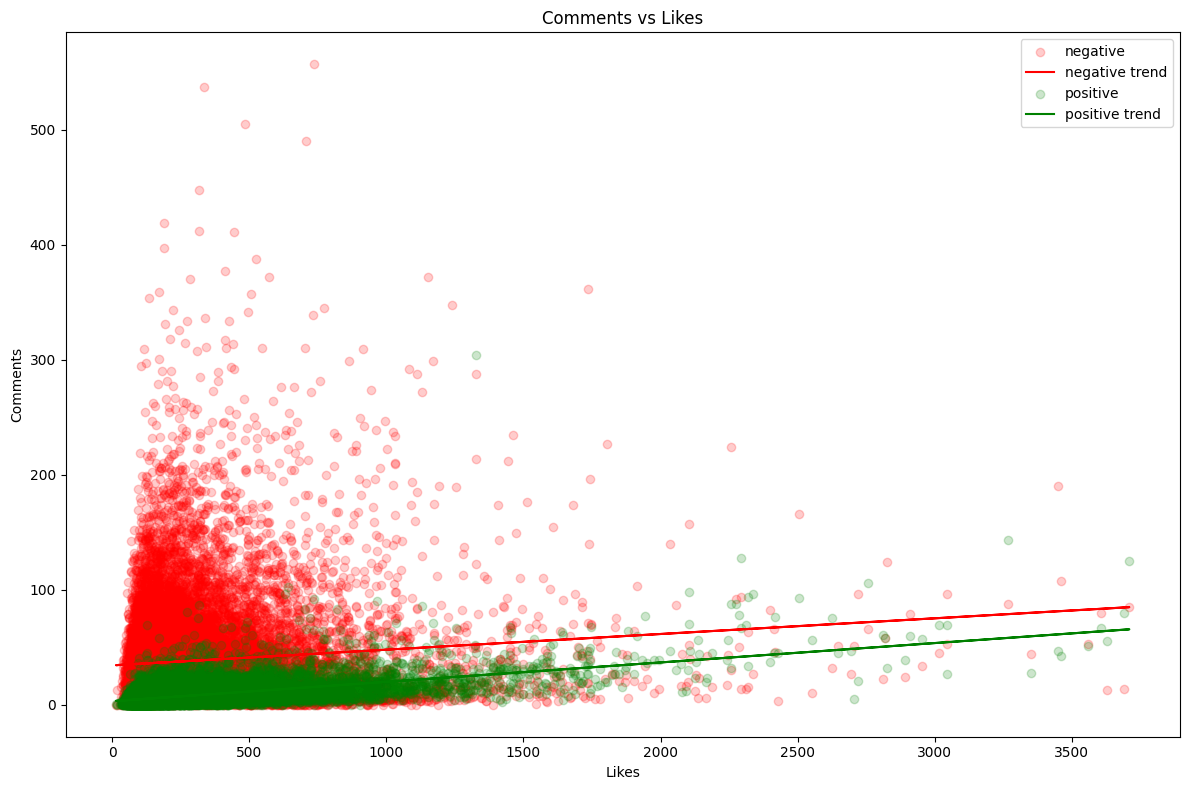

In [12]:
plot_dependence(df_vk[df_vk['likes'] < 4000])

В среднем, негативных комментариев больше чем позитивных. Это видно по и по распределению точек, и по трендовым линиям. Посмотрим каких комментариев больше для большого количества лайков.

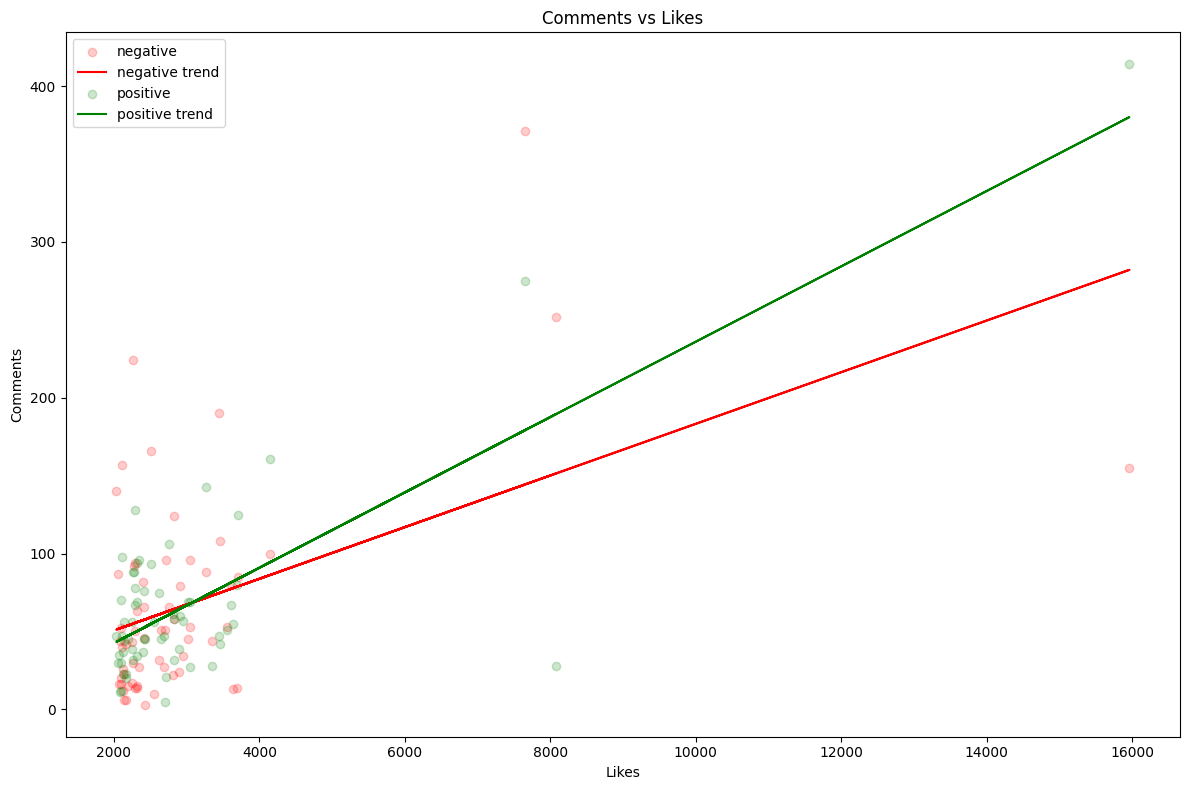

In [13]:
plot_dependence(df_vk[df_vk['likes'] > 2000])

По распределению сложно сказать каких больше, но трендовая говорит, что позитивных комментариев больше.

In [14]:
df_vk['total'] = df_vk[['negative_count', 'neutral_count', 'positive_count']].sum(axis = 1)

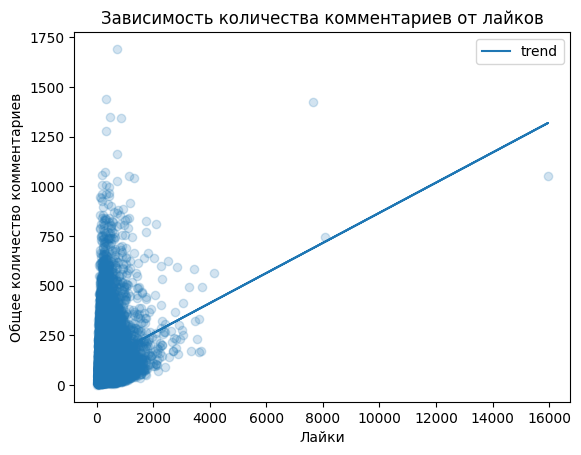

In [15]:
plt.scatter(df_vk['likes'], df_vk['total'], alpha=0.2)
coefficients = np.polyfit(df_vk['likes'], df_vk['total'], 1)
polynomial = np.poly1d(coefficients)
plt.plot(df_vk['likes'], polynomial(df_vk['likes']),  label = 'trend')
plt.legend()
plt.title('Зависимость количества комментариев от лайков')
plt.xlabel('Лайки')
plt.ylabel('Общее количество комментариев')
plt.show()

По распределению сложно судить о характере зависимости, но трендовая говорит, что позитивных комментариев больше. Коэффициент явно значимый, поскольку данных очень много и наклон достаточно большой.
Можно было бы ещё какой-нибудь коэффициент корреляции проверить на значимость, но тут и так всё понятно

__[0.2]__  Давайте построим по сентимент-окрасу комментариев топ позитивных новостей.

- Если под новостью оставлено 100 комментариев, из которых 80 позитивные, мы можем быть уверены в том, что новость была хорошо воспринята людьми.
- Если под новостью всего один комментарий и он оказался позитивным, то у нас 100% позитивных комментариев, но это вовсе не означает, что новость была воспринята хорошо.

Получается, что сортировать по доле позитивных комментариев нельзя. Давайте поступим умнее. Доля позитивных комментариев под постом -- это случайная величина. Её довольно часто моделируют с помощью бета-распределения. Если это случайная величина, мы можем построить для неё предиктивный интервал. Пусть $u$ - число позитивных комментариев, а $d$ - нейтральных и негативных.  Пусть

$$
a = 1 + u \qquad b = 1 + d.
$$

Тогда нижняя граница $95\%$ предиктивного интервала для доли будет вычисляться по такой формуле:

$$
\frac{a}{a + b} - 1.65 \cdot \sqrt{\frac{a \cdot b}{(a + b)^2 \cdot (a + b + 1)}}
$$

Если под новостью был всего один комментарий, у такой случайной величины будет высокая дисперсия. Это означаen, что штука, которую мы вычитаем из доли, окажется высокой. Левая граница интервала окажется маленькой и мы не поднимем комментарий в нашем топе наверх. Фактически мы делаем сортировку по квантилю уровня $0.05$ вместо среднего.

От вас требуется вбить эту формулу, сделать сортировку и вывести на экран топ позитивных новостей. Подробнее про то, откуда берётся эта формула можно почитать [в этой книге.](https://disk.yandex.ru/i/Ctd08bTwC9eI3g) Ищите 4 главу, страницу 140.

In [16]:
a = np.array(df_vk['positive_count']) + 1
b = np.array(df_vk['negative_count'] + df_vk['neutral_count']) + 1
beta = a/(a+b)-1.65*np.sqrt((a*b)/(np.square(a+b)*(a+b+1)))
df_vk['beta'] = beta
df_vk['beta']= df_vk['beta'].astype(float)

In [17]:
df_vk.sort_values(by = 'beta', ascending = False).head(10)

,id,href,datetime,title,likes,comments,snippet,title_clean,snippet_clean,target_tags,positive_count,neutral_count,negative_count,total,beta
13735,20128079,https://rsport.ria.ru/artist_gym/20180323/1134...,2018-03-23 07:19:58,Россиянка Мельникова победила в многоборье на ...,670,17,#UNKN,россиянка мельникова победила в многоборье на ...,#UNKN,спортивная гимнастика,11.0,3.0,0.0,14.0,0.576715
6651,22320852,https://rsport.ria.ru/rhythm_gym/20180913/1141...,2018-09-13 16:40:33,Сборная России выиграла командный турнир на че...,1387,53,#UNKN,сборная россии выиграла командный турнир на че...,#UNKN,художественная гимнастика,33.0,17.0,0.0,50.0,0.546021
7572,22073093,/culture/20180824/1527142299.html,2018-08-24 06:55:12,"Россиянин Иван Бессонов победил в конкурсе ""кл...",1882,119,#UNKN,россиянин иван бессонов победил в конкурсе кла...,#UNKN,культура,64.0,36.0,6.0,106.0,0.524488
12529,20591225,https://rsport.ria.ru/hockey/20180422/11358902...,2018-04-22 16:30:18,"""Ак Барс"" стал трехкратным обладателем Кубка Г...",1292,78,#UNKN,ак барс стал трехкратным обладателем кубка гаг...,#UNKN,хоккей,41.0,24.0,6.0,71.0,0.480533
2881,23318180,/incidents/20181205/1543512536.html,2018-12-05 20:10:42,В Балашихе спасли провалившегося под лед ребенка,544,27,#UNKN,в балашихе спасли провалившегося под лед ребенка,#UNKN,московская область,17.0,7.0,3.0,27.0,0.474520
2133,23489272,https://m.vk.com/narrative-15755094_9}?api_vie...,2018-12-20 15:17:09,"Ваши поздравления на елке ""Россия Сегодня"" в ГУМе",40,10,Мы обещали и мы сделали! Ваши новогодние поздр...,ваши поздравления на елке россия сегодня в гуме,мы обещали и мы сделали ваши новогодние поздра...,россия,6.0,2.0,0.0,8.0,0.472020
8122,21924284,https://rsport.ria.ru/aquatics/20180810/114028...,2018-08-10 21:34:38,Кузнецов и Захаров победили в синхронных прыжк...,1163,38,#UNKN,кузнецов и захаров победили в синхронных прыжк...,#UNKN,водные виды,20.0,11.0,2.0,33.0,0.465278
3735,23095458,https://rsport.ria.ru/aquatics/20181117/114611...,2018-11-17 12:18:00,Морозов во второй раз в карьере победил в обще...,460,17,#UNKN,морозов во второй раз в карьере победил в обще...,#UNKN,водные виды,10.0,5.0,0.0,15.0,0.461205
6933,22250884,https://rsport.ria.ru/others/20180907/11414159...,2018-09-07 11:31:40,Алипов и Рабая завоевали серебро в трапе среди...,366,13,#UNKN,алипов и рабая завоевали серебро в трапе среди...,#UNKN,спорт,8.0,4.0,0.0,12.0,0.438723
6508,22351029,https://rsport.ria.ru/rhythm_gym/20180916/1141...,2018-09-16 16:29:59,Сборная России выиграла медальный зачет ЧМ по ...,1585,62,Российские гимнастки завоевали семь золотых ме...,сборная россии выиграла медальный зачет чм по ...,российские гимнастки завоевали семь золотых ме...,художественная гимнастика,30.0,23.0,2.0,55.0,0.435949


Построили? Срочно пришлите свою любимую позитивную  новость в общий чат!!!

Топ негативных новостей строить не будем. Вокруг итак слишком много негатива 😻😻😻

__[0.2]__ Какие категории новостей оказались самыми позитивными? Придумайте способ найти такие категории и опишите его тут.

__Ответ:__ Cамые позитивные - это комментарии, связанные с победой наших спортсменов.

Найдем среднее значение беты по каждой категории и посмотри на топ.

In [18]:
print('Топ-10 позитивных категорий:')
print(*list(df_vk.groupby(by = 'target_tags').mean().sort_values(by = 'beta', ascending = False).reset_index().head(10)['target_tags']), sep = '\n')

Топ-10 позитивных категорий:
художественная гимнастика
новости - чемпионат мира по хоккею 2018
регби
паралимпизм
пляжный футбол
сборная россии - пхенчхан 2018
фигурное катание
водные виды
стрелковый спорт
пхенчхан 2018


<ipython-input-18-36b0eeb88180>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(*list(df_vk.groupby(by = 'target_tags').mean().sort_values(by = 'beta', ascending = False).reset_index().head(10)['target_tags']), sep = '\n')


__[0.2 бонусных]__ Проанализируйте, как температура комментария (вероятность того, что он негативный) зависит от длины трэда (число комментариев под новостью)? Значима ли эта взаимосвязь? Если вам для проверки этого хочется построить линейную регрессию, не сдерживайтесь.

In [20]:
df_comments['thread_length'] = df_comments['post_id']
length_dict = df_vk.set_index('id')['total'].to_dict()

#Пришлось разбить, поскольку на весь датафрейм не хватало ОЗУ.
chunk_size = 100000
num_chunks = (len(df_comments) // chunk_size) + 1

for i in range(num_chunks):
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, df_comments.shape[0])
    df_comments['thread_length'].iloc[start_idx:end_idx] = df_comments['thread_length'].iloc[start_idx:end_idx].replace(length_dict)

<ipython-input-20-c64d86ffb083>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comments['thread_length'].iloc[start_idx:end_idx] = df_comments['thread_length'].iloc[start_idx:end_idx].replace(length_dict)


In [25]:
import statsmodels.api as sm
data  = df_comments[df_comments['sentiment_verdict'] == 'negative']
mod = sm.OLS(data['sentiment_score'], data[['thread_length']])

res = mod.fit()

print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:        sentiment_score   R-squared (uncentered):                   0.602
Model:                            OLS   Adj. R-squared (uncentered):              0.602
Method:                 Least Squares   F-statistic:                          1.155e+06
Date:                Sun, 17 Dec 2023   Prob (F-statistic):                        0.00
Time:                        13:13:29   Log-Likelihood:                     -4.5333e+05
No. Observations:              764109   AIC:                                  9.067e+05
Df Residuals:                  764108   BIC:                                  9.067e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

Как можно видеть, коэффициент перед thread_length значимый. Говорить о его величине достаточно сложно (надо считать всякие коэффициенты эластичности), но взаимосвязь есть. Взаимосвязь положительная - чем длинее тред, тем больше вероятность негативного комментария.